## Step 1: Install Dependencies and Load Data

In [1]:
# Install required packages
%pip install pandas numpy scikit-learn xgboost matplotlib seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [3]:
# Load the cleaned customer data
df = pd.read_csv('../data/cleaned_customer_data.csv')

print(f"Dataset loaded: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

Dataset loaded: (187, 10)

Columns: ['customer_id_clean', 'transaction_id', 'purchase_date', 'product_category', 'purchase_amount', 'customer_rating', 'social_media_platform', 'engagement_score', 'purchase_interest_score', 'review_sentiment']

First few rows:
   customer_id_clean  transaction_id purchase_date product_category  \
0                151            1001    2024-01-01           Sports   
1                151            1001    2024-01-01           Sports   
2                192            1002    2024-01-02      Electronics   
3                114            1003    2024-01-03      Electronics   
4                160            1005    2024-01-05         Clothing   

   purchase_amount  customer_rating social_media_platform  engagement_score  \
0              408              2.3                TikTok                61   
1              408              2.3               Twitter                72   
2              332              4.2             Instagram                60 

## Step 2: Exploratory Data Analysis

In [4]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

print(f"\nDataset info:")
print(df.info())

print(f"\nNumerical columns summary:")
print(df.describe())

Missing values:
customer_id_clean          0
transaction_id             0
purchase_date              0
product_category           0
purchase_amount            0
customer_rating            0
social_media_platform      0
engagement_score           0
purchase_interest_score    0
review_sentiment           0
dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id_clean        187 non-null    int64  
 1   transaction_id           187 non-null    int64  
 2   purchase_date            187 non-null    object 
 3   product_category         187 non-null    object 
 4   purchase_amount          187 non-null    int64  
 5   customer_rating          187 non-null    float64
 6   social_media_platform    187 non-null    object 
 7   engagement_score         187 non-null    int64  
 8   purchase_interes

Product Category Distribution:
product_category
Sports         48
Electronics    40
Groceries      34
Books          34
Clothing       31
Name: count, dtype: int64


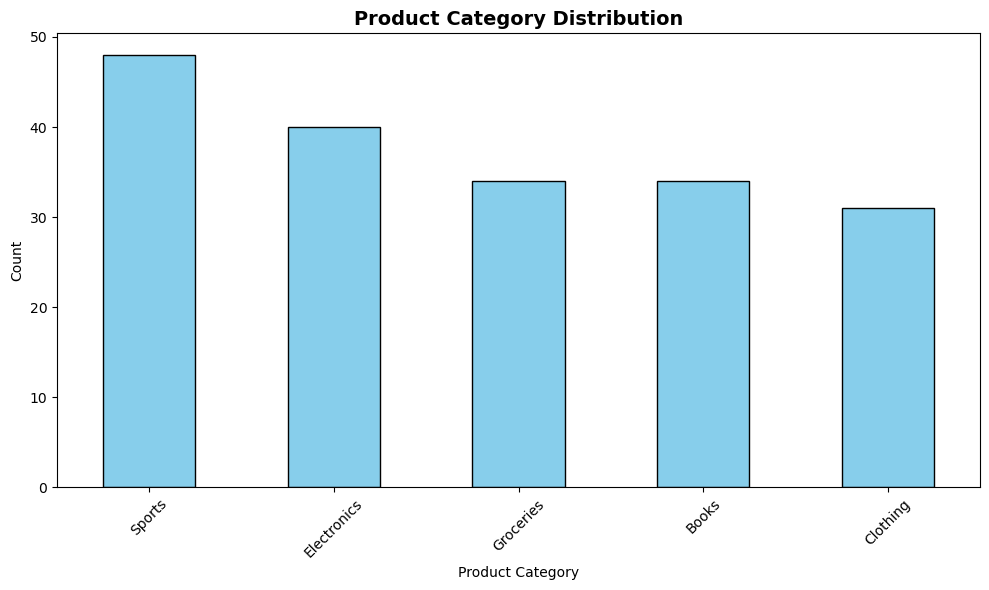

In [5]:
# Target variable distribution
print("Product Category Distribution:")
print(df['product_category'].value_counts())

# Visualization
plt.figure(figsize=(10, 6))
df['product_category'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Product Category Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Step 3: Feature Engineering

In [6]:
# Convert purchase_date to datetime
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

# Extract temporal features
df['purchase_month'] = df['purchase_date'].dt.month
df['purchase_day_of_week'] = df['purchase_date'].dt.dayofweek
df['purchase_quarter'] = df['purchase_date'].dt.quarter

# Customer-level aggregations
customer_stats = df.groupby('customer_id_clean').agg({
    'purchase_amount': ['mean', 'sum', 'count', 'std'],
    'customer_rating': 'mean',
    'engagement_score': 'mean',
    'purchase_interest_score': 'mean'
}).reset_index()

# Flatten column names
customer_stats.columns = ['customer_id_clean', 'avg_purchase', 'total_spent', 
                          'purchase_count', 'purchase_std', 'avg_rating', 
                          'avg_engagement', 'avg_interest']

# Merge back to main dataframe
df = df.merge(customer_stats, on='customer_id_clean', how='left')

# Fill missing values
df['purchase_std'] = df['purchase_std'].fillna(0)

print(f"✅ Feature engineering complete!")
print(f"New shape: {df.shape}")
print(f"\nNew features created:")
print([col for col in df.columns if col not in pd.read_csv('../data/cleaned_customer_data.csv').columns])

✅ Feature engineering complete!
New shape: (187, 20)

New features created:
['purchase_month', 'purchase_day_of_week', 'purchase_quarter', 'avg_purchase', 'total_spent', 'purchase_count', 'purchase_std', 'avg_rating', 'avg_engagement', 'avg_interest']


## Step 4: Encode Categorical Variables

In [7]:
# Encode social media platform
platform_encoder = LabelEncoder()
df['platform_encoded'] = platform_encoder.fit_transform(df['social_media_platform'])

# Encode review sentiment
sentiment_encoder = LabelEncoder()
df['sentiment_encoded'] = sentiment_encoder.fit_transform(df['review_sentiment'])

# Encode target variable (product_category)
category_encoder = LabelEncoder()
df['category_encoded'] = category_encoder.fit_transform(df['product_category'])

print("Encoding mappings:")
print(f"\nPlatforms: {dict(zip(platform_encoder.classes_, platform_encoder.transform(platform_encoder.classes_)))}")
print(f"\nSentiments: {dict(zip(sentiment_encoder.classes_, sentiment_encoder.transform(sentiment_encoder.classes_)))}")
print(f"\nCategories: {dict(zip(category_encoder.classes_, category_encoder.transform(category_encoder.classes_)))}")

print(f"\n✅ Categorical encoding complete!")

Encoding mappings:

Platforms: {'Facebook': 0, 'Instagram': 1, 'LinkedIn': 2, 'TikTok': 3, 'Twitter': 4}

Sentiments: {'Negative': 0, 'Neutral': 1, 'Positive': 2}

Categories: {'Books': 0, 'Clothing': 1, 'Electronics': 2, 'Groceries': 3, 'Sports': 4}

✅ Categorical encoding complete!


## Step 5: Prepare Features and Target

In [8]:
# Select features for model training
feature_columns = [
    # Original features
    'purchase_amount',
    'customer_rating',
    'engagement_score',
    'purchase_interest_score',
    
    # Encoded categorical features
    'platform_encoded',
    'sentiment_encoded',
    
    # Temporal features
    'purchase_month',
    'purchase_day_of_week',
    'purchase_quarter',
    
    # Customer aggregation features
    'avg_purchase',
    'total_spent',
    'purchase_count',
    'purchase_std',
    'avg_rating',
    'avg_engagement',
    'avg_interest'
]

X = df[feature_columns]
y = df['category_encoded']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

Features shape: (187, 16)
Target shape: (187,)

Features used (16):
  1. purchase_amount
  2. customer_rating
  3. engagement_score
  4. purchase_interest_score
  5. platform_encoded
  6. sentiment_encoded
  7. purchase_month
  8. purchase_day_of_week
  9. purchase_quarter
  10. avg_purchase
  11. total_spent
  12. purchase_count
  13. purchase_std
  14. avg_rating
  15. avg_engagement
  16. avg_interest


## Step 6: Split Data and Scale Features

In [9]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Data split and scaled successfully!")
print(f"\nClass distribution in training set:")
for category, count in zip(*np.unique(y_train, return_counts=True)):
    category_name = category_encoder.inverse_transform([category])[0]
    print(f"  {category_name}: {count} ({count/len(y_train)*100:.1f}%)")

Training set: (149, 16)
Testing set: (38, 16)

✅ Data split and scaled successfully!

Class distribution in training set:
  Books: 27 (18.1%)
  Clothing: 25 (16.8%)
  Electronics: 32 (21.5%)
  Groceries: 27 (18.1%)
  Sports: 38 (25.5%)


## Step 7: Train Multiple Models

In [11]:
# Initialize models
models = {}

print("Training models...\n")
print("="*60)

# 1. Random Forest
print("\n[1/3] Training Random Forest...")
models['RandomForest'] = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)
models['RandomForest'].fit(X_train_scaled, y_train)
print("✅ Random Forest trained")

# 2. Logistic Regression
print("\n[2/3] Training Logistic Regression...")
models['LogisticRegression'] = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    multi_class='multinomial'
)
models['LogisticRegression'].fit(X_train_scaled, y_train)
print("✅ Logistic Regression trained")

# 3. XGBoost
print("\n[3/3] Training XGBoost...")
models['XGBoost'] = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)
models['XGBoost'].fit(X_train_scaled, y_train)
print("✅ XGBoost trained")

print("\n" + "="*60)
print("All models trained successfully!")
print("="*60)

Training models...


[1/3] Training Random Forest...
✅ Random Forest trained

[2/3] Training Logistic Regression...
✅ Random Forest trained

[2/3] Training Logistic Regression...
✅ Logistic Regression trained

[3/3] Training XGBoost...
✅ Logistic Regression trained

[3/3] Training XGBoost...
✅ XGBoost trained

All models trained successfully!
✅ XGBoost trained

All models trained successfully!


## Step 8: Evaluate and Compare Models

In [12]:
# Evaluate each model
results = []

for name, model in models.items():
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # F1 Score
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Train_Accuracy': f"{train_acc:.4f}",
        'Test_Accuracy': f"{test_acc:.4f}",
        'Train_F1': f"{train_f1:.4f}",
        'Test_F1': f"{test_f1:.4f}"
    })

# Display results
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)


MODEL COMPARISON
             Model Train_Accuracy Test_Accuracy Train_F1 Test_F1
      RandomForest         0.8993        0.6053   0.8989  0.5963
LogisticRegression         0.5235        0.5263   0.5189  0.4987
           XGBoost         1.0000        0.8158   1.0000  0.8168


In [13]:
# Select best model based on test accuracy
best_model_name = max(models.keys(), 
                      key=lambda k: accuracy_score(y_test, models[k].predict(X_test_scaled)))
best_model = models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Test Accuracy: {accuracy_score(y_test, best_model.predict(X_test_scaled)):.4f}")


🏆 Best Model: XGBoost
Test Accuracy: 0.8158


## Step 9: Detailed Evaluation of Best Model

In [14]:
# Classification report
y_pred_best = best_model.predict(X_test_scaled)

print("\nClassification Report:")
print("="*70)
print(classification_report(y_test, y_pred_best, 
                           target_names=category_encoder.classes_))
print("="*70)


Classification Report:
              precision    recall  f1-score   support

       Books       1.00      1.00      1.00         7
    Clothing       0.71      0.83      0.77         6
 Electronics       0.67      0.75      0.71         8
   Groceries       0.86      0.86      0.86         7
      Sports       0.88      0.70      0.78        10

    accuracy                           0.82        38
   macro avg       0.82      0.83      0.82        38
weighted avg       0.83      0.82      0.82        38



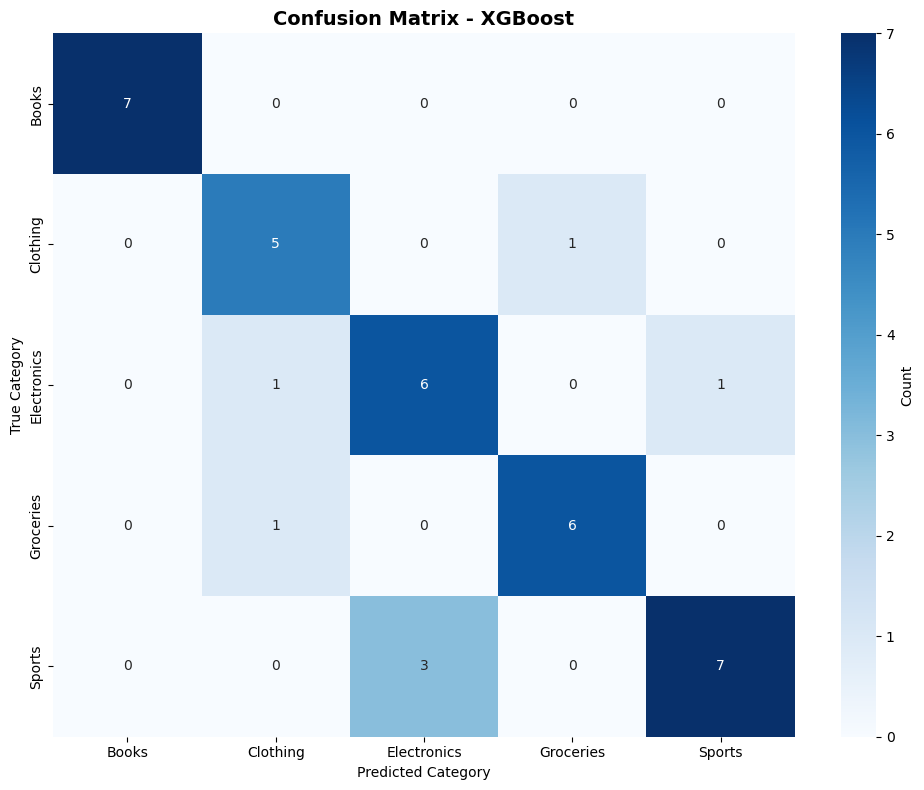


Per-Class Accuracy:
  Books: 100.00%
  Clothing: 83.33%
  Electronics: 75.00%
  Groceries: 85.71%
  Sports: 70.00%


In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=category_encoder.classes_,
            yticklabels=category_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Category')
plt.xlabel('Predicted Category')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, category in enumerate(category_encoder.classes_):
    class_acc = cm[i, i] / cm[i].sum()
    print(f"  {category}: {class_acc:.2%}")


Top 10 Most Important Features:
             Feature  Importance
        avg_purchase    0.112881
         total_spent    0.100437
purchase_day_of_week    0.094856
    platform_encoded    0.077927
     purchase_amount    0.074163
      purchase_month    0.067963
        avg_interest    0.064311
    engagement_score    0.060552
     customer_rating    0.058762
      purchase_count    0.055987


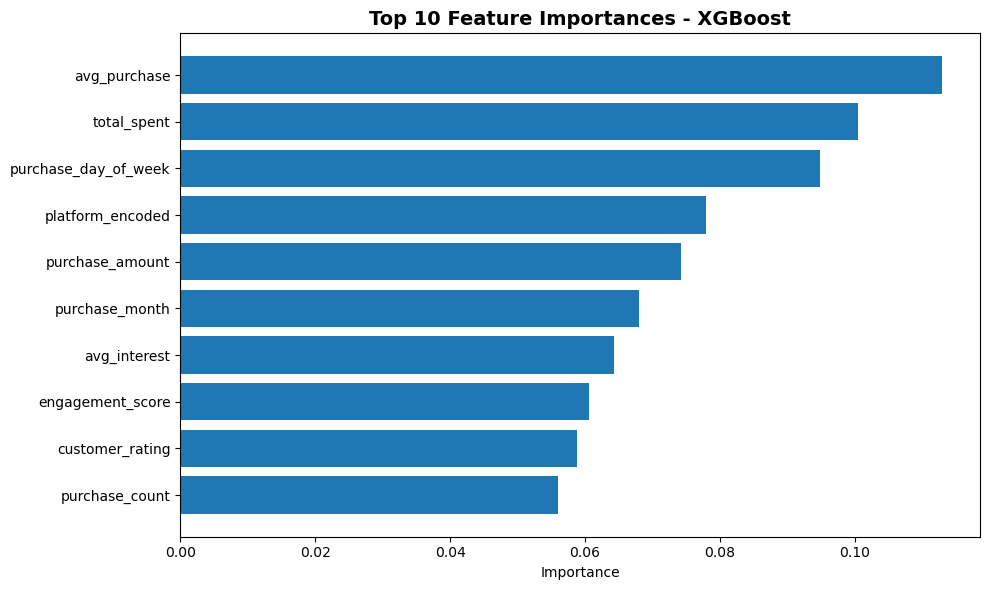

In [16]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10).to_string(index=False))
    
    # Visualization
    plt.figure(figsize=(10, 6))
    top_features = feature_importance_df.head(10)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Feature Importances - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## Step 10: Save Model and Artifacts

In [17]:
# Save best model
model_path = f'best_model_{best_model_name}.pkl'
joblib.dump(best_model, model_path)
print(f"✅ Model saved: {model_path}")

# Save scaler
scaler_path = 'product_category_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved: {scaler_path}")

# Save encoders and feature list
artifacts = {
    'category_encoder': category_encoder,
    'platform_encoder': platform_encoder,
    'sentiment_encoder': sentiment_encoder,
    'feature_columns': feature_columns,
    'best_model_name': best_model_name
}

artifacts_path = 'product_category_artifacts.pkl'
with open(artifacts_path, 'wb') as f:
    pickle.dump(artifacts, f)
print(f"✅ Artifacts saved: {artifacts_path}")

print("\n" + "="*70)
print("🎉 MODEL TRAINING COMPLETE!")
print("="*70)
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_best):.2%}")
print(f"Test F1 Score: {f1_score(y_test, y_pred_best, average='weighted'):.4f}")
print("\nFiles saved:")
print(f"  - {model_path}")
print(f"  - {scaler_path}")
print(f"  - {artifacts_path}")
print("="*70)

✅ Model saved: best_model_XGBoost.pkl
✅ Scaler saved: product_category_scaler.pkl
✅ Artifacts saved: product_category_artifacts.pkl

🎉 MODEL TRAINING COMPLETE!
Best Model: XGBoost
Test Accuracy: 81.58%
Test F1 Score: 0.8168

Files saved:
  - best_model_XGBoost.pkl
  - product_category_scaler.pkl
  - product_category_artifacts.pkl


## Step 11: Test Prediction Function

In [18]:
def predict_product_category(customer_features, model, scaler, encoders, feature_cols):
    """
    Predict product category for a customer
    
    Args:
        customer_features: dict with customer information
        model: trained model
        scaler: feature scaler
        encoders: dict of label encoders
        feature_cols: list of feature column names
    
    Returns:
        dict with prediction and probability
    """
    # Create feature vector
    features = np.array([customer_features[col] for col in feature_cols]).reshape(1, -1)
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Predict
    prediction = model.predict(features_scaled)[0]
    probabilities = model.predict_proba(features_scaled)[0]
    
    # Decode prediction
    category = encoders['category_encoder'].inverse_transform([prediction])[0]
    confidence = probabilities[prediction]
    
    # Get all probabilities
    all_probs = dict(zip(encoders['category_encoder'].classes_, probabilities))
    
    return {
        'predicted_category': category,
        'confidence': confidence,
        'all_probabilities': all_probs
    }

print("✅ Prediction function defined")

✅ Prediction function defined


In [19]:
# Test prediction on a sample from test set
test_idx = 0
test_features = dict(zip(feature_columns, X_test.iloc[test_idx].values))
true_category = category_encoder.inverse_transform([y_test.iloc[test_idx]])[0]

print("Test Sample Features:")
for key, value in test_features.items():
    print(f"  {key}: {value}")

result = predict_product_category(
    test_features, 
    best_model, 
    scaler, 
    artifacts, 
    feature_columns
)

print("\n" + "="*60)
print("PREDICTION RESULT")
print("="*60)
print(f"Predicted Category: {result['predicted_category']}")
print(f"True Category: {true_category}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"\nProbabilities for all categories:")
for category, prob in sorted(result['all_probabilities'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {category}: {prob:.2%}")
print("="*60)

Test Sample Features:
  purchase_amount: 395.0
  customer_rating: 1.1
  engagement_score: 83.0
  purchase_interest_score: 1.4
  platform_encoded: 0.0
  sentiment_encoded: 2.0
  purchase_month: 1.0
  purchase_day_of_week: 5.0
  purchase_quarter: 1.0
  avg_purchase: 253.33333333333334
  total_spent: 1520.0
  purchase_count: 6.0
  purchase_std: 140.16656757824478
  avg_rating: 1.5999999999999999
  avg_engagement: 69.5
  avg_interest: 2.1999999999999997

PREDICTION RESULT
Predicted Category: Groceries
True Category: Groceries
Confidence: 97.40%

Probabilities for all categories:
  Groceries: 97.40%
  Sports: 1.55%
  Books: 0.51%
  Clothing: 0.36%
  Electronics: 0.18%
